In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [76]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [3]:
from typing import Tuple

import pandas as pd

from plotting import plot_ts
from load_dataset import Dataset
from model import TimeSeriesPredictor
import numpy as np

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from monthdelta import monthmod, monthdelta

### Какие ряды будем тестировать?

* длинный ряд с сезонностью  
* короткий ряд с сезонностью  
* короткий ряд с сезонностью и трендом  
* случайное блуждание  
* средне зашумленный ряд
* "шумный" ряд  

In [5]:
ds = Dataset('../data/dataset/')

In [6]:
long = ds['daily-min-temperatures.csv']

In [7]:
plot_ts(long)

Loading BokehJS ...

In [8]:
short_season = ds['hour_3019.csv'][300:]

In [9]:
plot_ts(short_season);

Loading BokehJS ...

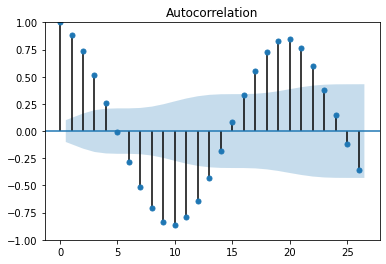

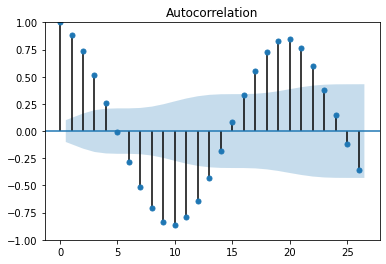

In [10]:
plot_acf(short_season)

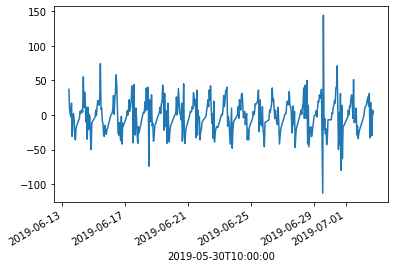

In [11]:
short_season.diff().plot()

In [12]:
short_season_trend = ds['international-airline-passengers.csv']

In [13]:
plot_ts(short_season_trend)

Loading BokehJS ...

In [14]:
plot_ts(np.log(short_season_trend) )

Loading BokehJS ...

In [15]:
short_season_trend_log = np.log(short_season_trend)

In [16]:
k, b = np.polyfit(range(len(short_season_trend_log)), short_season_trend_log.values, 1)


In [17]:
trend = pd.Series(k * np.array(range(len(short_season_trend_log))) + b, index=short_season_trend_log.index)

In [18]:
short_season_trend_log_detr = short_season_trend_log - trend

In [19]:
plot_ts(short_season_trend_log - trend )

Loading BokehJS ...

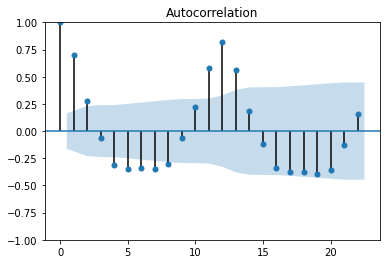

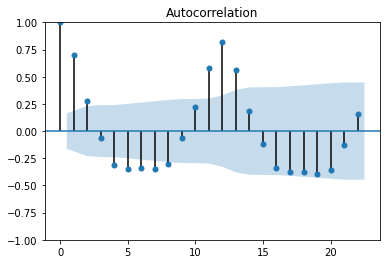

In [20]:
plot_acf(short_season_trend_log_detr)

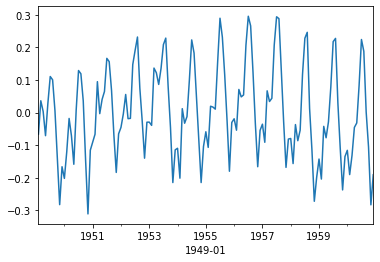

In [21]:
short_season_trend_log_detr.plot()

In [22]:
random_walk = ds['dow_jones_0.csv']

In [23]:
plot_ts(random_walk)

Loading BokehJS ...

In [24]:
medium_noize = ds['hour_3426.csv'][300:]

In [25]:
plot_ts(medium_noize)

Loading BokehJS ...

In [26]:
full_noize = ds['day_1574.csv']

In [27]:
plot_ts(full_noize)

Loading BokehJS ...

### Какие модели будем тестировать?

* скользящее среднее
* экспоненциальное сглаживание
* autoArima
* линейная регрессия
* линейная регрессия с L1 регуляризацией (Ridge)
* RandomForeset
* градиентный бустинг


In [28]:
from estimators import RollingEstimator, ExponentialSmoothingEstimator
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### По каким метрикам будем сравнивать?

* mse
* mae
* R2
* mape - если не будет ломаться на нулях
* mase

In [29]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from metrics import mean_absolute_percentage_error as mape
from metrics import mase

### По какой методике будем тестировать?

* 70% трейн, 30% тест
* Out-of-sample, чтобы посмотреть как модель предсказывает "вдолгую"
* In-Sample, чтобы посмотреть как модель предсказывает на одну точку вперед
* Для поиска гиперпараметров можно делать кроссвалидацию на тесте по метрике mse

### Задание 1. Напишите функцию, разбивающую на train и test

In [30]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_idx = int(len(ts) * ratio)
    ts_train, ts_test = ts[:split_idx], ts[split_idx:]
    return ts_train, ts_test

### Зададим соответствие гранулярностей для наших рядов.

### Задание 2. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через TimeSeriesPredictor.

* принмает на вход исходный ряд, гранулярность, количество лагов, модель, а также **kwargs, в которые мы будем передавать параметры модели

* разбивает ряд на train/test

* создает инстанс TimeSeriesPredictor с нужными параметрами

* обучает предиктор на трейне

* делает out_of_sample и in_sample прогноз

* возвращает train, test, in_sample, out_of_sample

### Задание 3. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через auto_arima

* функция должна принимать исходный временной ряд, период сезонности, параметры дифференцирования d, D и boolean параметр seasonal, данные параметры будут являться для нас гиперпараметрами, все остальное за нас должна найти auto_arima

* разбивает на train, test

* обучает arima на train при помощи вызова функции auto_arima из библиотеки pmdarima с переданными параметрами и со следующими зафиксированными параметрами: `max_p=3, max_q=3, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True`

* в качестве out_of_sample прогноза просто вызовите метод predict

* в качестве in_sample прогноза обучите модель заново на всём ряде методом `fit`, вызовите метод predict_in_sample и в качестве прогноза возьмите `in_sample_predictions(-len(test):)`

* возвращает train, test, in_sample, out_of_sample (не забудьте сделать их pd.Series с нужным индексом!!)

In [286]:
import isodate

def make_pipeline(ts: pd.Series, granularity: str, num_lags: int, model: callable, **kwargs) -> Tuple[pd.Series]:
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model
    )
    predictor.set_params(**kwargs)
    predictor.fit(ts)
    
    in_sample = predictor.predict_batch(train, test)
    
    first_dttm, last_dttm = train.index[-1], test.index[-1]
    # Обработка для случая гранулярности в месяц
    if granularity == 'P1M':
        horizon = monthmod(first_dttm, last_dttm)[0].months
    else:
        horizon = (last_dttm - first_dttm) / isodate.parse_duration(granularity)
    out_of_sample = predictor.predict_next(train, n_steps=int(horizon))
    out_of_sample = out_of_sample[test.index]
    
    return train, test, in_sample, out_of_sample

In [287]:
def make_pipeline_arima(
    ts: pd.Series, granularity: str,  period: int, d: int = 1, D: int = 1, seasonal: bool = True) -> Tuple[pd.Series]:
    train, test = train_test_split(ts)
    arima_fit = auto_arima(
        train,
        max_p=3, max_q=3, m=period,
        seasonal=seasonal,
        d=d, D=D,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    
    first_dttm, last_dttm = train.index[-1], test.index[-1]
    # Обработка для случая гранулярности в месяц
    if granularity == 'P1M':
        horizon = monthmod(first_dttm, last_dttm)[0].months
        pd_freq = pd.DateOffset(months=1)
    else:
        horizon = (last_dttm - first_dttm) / isodate.parse_duration(granularity)
        pd_freq = pd.DateOffset(seconds=isodate.parse_duration(granularity).total_seconds())
    out_of_sample = pd.Series(
        data=arima_fit.predict(int(horizon) + 1) ,
        index=pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)
    )
    out_of_sample = out_of_sample[test.index]
    
    in_sample = pd.Series(arima_fit.predict_in_sample()[-len(test):], index=test.index)
    
    return train, test, in_sample, out_of_sample

### Задание 4. Напишите функцию, имплементирующую поиск гиперпараметров по сетке. 

* функция должна принимать на вход ряд, гранулярность, модель, дефолтное количество лагов, сетку параметров (словарь)
* после написанного мной кода, функция должна с текущими параметрами запустить пайплайн (функция make_pipeline), получив таким образом прогнозы in_sample и out_of_sample
* посчитать mse для in_sample и out_of_sample прогноза, запомнить их в соответствующие словари
* вернуть лучшие параметры для in_sample и out_of_sample прогнозов

Замечания
* не забудьте, что в сетку параметров можно передавать также num_lags
* если в ряде ts_test есть пропуски, индекс прогноза out_of_sample будет не совпадать c индексом реальных данных, в таком случае, замените индекс out_of_sample прогноза индексом ts_test

In [33]:
# import isodate

# def make_pipeline(ts: pd.Series, granularity: str, num_lags: int, model: callable, **kwargs) -> Tuple[pd.Series]:
#     train, test = train_test_split(ts)
    
#     predictor = TimeSeriesPredictor(
#         granularity=granularity,
#         num_lags=num_lags,
#         model=model
#     )
#     predictor.set_params(**kwargs)
#     predictor.fit(ts)
    
#     in_sample = predictor.predict_batch(train, test)
    
#     first_dttm, last_dttm = train.index[-1], test.index[-1]
#     horizon = (last_dttm - first_dttm) / isodate.parse_duration(granularity)
#     out_of_sample = predictor.predict_next(train, n_steps=horizon)
#     out_of_sample = out_of_sample[test.index]
    
#     return train, test, in_sample, out_of_sample

In [34]:
from itertools import product

def hyperparameters_search(ts, granularity, model, num_lags, param_grid, verbose=False):    
    statistics_in_sample, statistics_out_of_sample = [], []

    for param_tuple in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), param_tuple))
        
        # если в сетке есть num_lags, берем его, если нет, берем дефолтный num_lags из сигнатуры функции
        num_lags = params.pop('num_lags', None) or num_lags
        
        train, test, in_sample, out_of_sample = make_pipeline(ts, granularity, num_lags, model, **params )
        
        error_in_sample = mse(test, in_sample)
        error_out_of_sample = mse(test, out_of_sample)
        
        params['num_lags'] = num_lags
        
        statistics_in_sample.append((params, error_in_sample))
        statistics_out_of_sample.append((params, error_out_of_sample))
        
    
    best_in_sample = sorted(statistics_in_sample, key=lambda tup: tup[1])[0][1]
    best_out_of_sample = sorted(statistics_out_of_sample, key=lambda tup: tup[1])[0][1]
    best_out_of_sample_params = sorted(statistics_out_of_sample, key=lambda tup: tup[1])[0][0]
    
    return best_in_sample, best_out_of_sample,best_out_of_sample_params
    
        
        
        
        

### Задание 5. "Прогоните" все алгоритмы на всех рядах и получите сводную таблицу результатов по всем метрикам, постройте также графики прогнозов. 

In [35]:
from estimators import RollingEstimator, ExponentialSmoothingEstimator
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [36]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from metrics import mean_absolute_percentage_error as mape
from metrics import mase

In [236]:
granularity_mapping = {
    'long': 'P1D',
    'short_season': 'PT1H',
    'short_season_trend': 'P1M',
    'random_walk': 'P1D',
    'medium_noise': 'PT1H',
    'full_noise': 'P1D'
}

In [292]:
dataset_mapping = {
    "long": long,
    "short_season": short_season,
    "short_season_trend": short_season_trend,
    "random_walk": random_walk, 
    "medium_noise": medium_noize,
    "full_noise": full_noize
}

In [293]:
dataset_arima_mapping = {
        "long": None,
    "short_season": (20, 1, 1, True),
    "short_season_trend": (12, 1, 1, True),
    "random_walk": (0, 1, 1, False), 
    "medium_noise": (0, 1, 1, False),
    "full_noise": (0, 1, 1, False)
}

In [294]:
param_grid_default = {
    'num_lags': [12, 24, 36]
}

In [295]:
param_grid_ridge = {
    'num_lags': [12, 24, 36],
    'model__alpha': [0, 1, 3, 10],
    'model__normalize': [True, False]
}

In [296]:
param_grid_rf = {
    'num_lags': [12, 24, ],
    'model__max_depth': list(range(4, 6)),
    'model__n_estimators': [ 50,  100]
}

In [297]:
param_grid_gb = {
    'num_lags': [12, 24],
    'model__max_depth': [3, 4, 5],
    'model__subsample': np.arange(.8, 1.01, .1),
    'model__n_estimators': [50,  100]
}

In [298]:
param_grid_exp_smoothing = {
    'num_lags': [12, 24, 36],
    'model__alpha_coef': np.arange(.1, .9, .1)
}

In [299]:
models_mapping = {
    "rolling": (RollingEstimator, param_grid_default),
    "exponential_smoothing": (ExponentialSmoothingEstimator, param_grid_exp_smoothing),
    "auto_arima": (auto_arima, None),
    "linear_reg": (LinearRegression, param_grid_default),
    "ridge": (Ridge, param_grid_ridge),
    "rf": (RandomForestRegressor, param_grid_rf),
    "gb": (GradientBoostingRegressor, param_grid_gb)
}

In [300]:
metrics_mapping = {
    'mse': mse,
    'mae': mae,
    'r2': r2_score,
    "mase": mase
}

In [301]:
default_num_lags = 12

In [302]:
final_results = []

for dataset_name, dataset in dataset_mapping.items():
    print('Dataset:', dataset_name)
    for model_name, (model, params_grid) in models_mapping.items():
        print('Model:', model_name)
        dataset_gran = granularity_mapping[dataset_name]

        res_model = {}

        res_model['dataset'] = dataset_name

        res_model['model'] = model_name

        if model_name == 'auto_arima':
            # пропускаем auto_arima для датасета long
            if dataset_name == 'long':
                continue
            period, d, D, seasonal = dataset_arima_mapping[dataset_name]
            _, test, in_sample_best, out_of_sample_best = \
                make_pipeline_arima(dataset, dataset_gran, period=period, d=d, D=D, seasonal=seasonal)
        else:

            best_in_sample, best_out_of_sample, best_out_of_sample_params = \
                hyperparameters_search(dataset, dataset_gran, model, default_num_lags, params_grid )

            num_lags = best_out_of_sample_params.pop('num_lags', None)

            _, test, in_sample_best, out_of_sample_best = \
                make_pipeline(dataset, dataset_gran, num_lags, model, **best_out_of_sample_params)

        for metr_name, metric in metrics_mapping.items():
            res_model[metr_name+'_ins'] = metric(test, in_sample_best)
            res_model[metr_name+'_oos'] = metric(test, out_of_sample_best) 
        final_results.append(res_model)

Dataset: long
Model: rolling
Model: exponential_smoothing
Model: auto_arima
Model: linear_reg
Model: ridge
Model: rf
Model: gb
Dataset: short_season
Model: rolling
Model: exponential_smoothing
Model: auto_arima
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[20]             : AIC=2137.047, Time=1.72 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=2231.580, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=2139.680, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=2133.283, Time=0.64 sec
 ARIMA(0,1,1)(0,1,0)[20]             : AIC=2175.376, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[20]             : AIC=2135.139, Time=1.04 sec
 ARIMA(0,1,1)(0,1,2)[20]             : AIC=2135.188, Time=1.84 sec
 ARIMA(0,1,1)(1,1,0)[20]             : AIC=2138.821, Time=0.39 sec
 ARIMA(0,1,1)(1,1,2)[20]             : AIC=2135.956, Time=3.01 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=2146.677, Time=0.30 sec
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=2134.638, Time=0.89 sec
 ARIMA(0,

# Финальные результаты

In [205]:
# debug

In [238]:
dataset_name = 'short_season'
   
    
    # 'short_season_trend': 'P1M',


In [239]:
dataset = dataset_mapping[dataset_name]

In [240]:
dataset_gran = granularity_mapping[dataset_name]


In [241]:
print(dataset_gran)

PT1H


In [242]:
dataset

2019-05-30T10:00:00
2019-06-13 09:00:00     71.0
2019-06-13 10:00:00    108.0
2019-06-13 11:00:00    117.0
2019-06-13 12:00:00    119.0
2019-06-13 13:00:00    116.0
                       ...  
2019-07-02 14:00:00    132.0
2019-07-02 15:00:00    128.0
2019-07-02 16:00:00     98.0
2019-07-02 17:00:00    105.0
2019-07-02 18:00:00    107.0
Name: 96.0, Length: 381, dtype: float64

In [243]:
ts = dataset

In [244]:
# granularity = dataset_gran
granularity = dataset_gran



In [245]:
num_lags = 12

In [246]:
kwargs = {}

In [247]:
train, test = train_test_split(ts)



predictor = TimeSeriesPredictor(
    granularity=granularity,
    num_lags=num_lags,
    model=model
)
predictor.set_params(**kwargs)
predictor.fit(ts)

in_sample = predictor.predict_batch(train, test)



In [274]:
arima_fit = auto_arima(
        train,
        max_p=3, max_q=3, m=0,
        seasonal=False,
        d=1, D=0,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2413.817, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2387.237, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2397.490, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2411.819, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2369.030, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2368.937, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2367.016, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2370.088, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2232.005, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2229.591, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2365.381, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2365.585, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2

In [248]:
first_dttm, last_dttm = train.index[-1], test.index[-1]


In [252]:
first_dttm

Timestamp('2019-06-26 19:00:00')

In [251]:
last_dttm

Timestamp('2019-07-02 18:00:00')

In [253]:
delta = (last_dttm - first_dttm)

In [279]:
delta / np.timedelta64(1, 'h')

143.0

In [255]:
isodate.parse_duration(granularity)

datetime.timedelta(seconds=3600)

In [256]:
granularity

'PT1H'

In [258]:
horizon = (last_dttm - first_dttm) / isodate.parse_duration(granularity)


In [259]:
horizon

143.0

In [266]:
pd_freq = pd.DateOffset(seconds=isodate.parse_duration(granularity).total_seconds())


In [275]:
out_of_sample = pd.Series(
        data=arima_fit.predict(int(horizon)) ,
        index=pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)
    )

ValueError: Length of values (143) does not match length of index (144)

In [268]:
index=pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)


In [270]:
index.shape

(144,)

In [271]:
index.min()

Timestamp('2019-06-26 19:00:00', freq='<DateOffset: seconds=3600.0>')

In [273]:
index.max()

Timestamp('2019-07-02 18:00:00', freq='<DateOffset: seconds=3600.0>')

In [215]:
monthmod(last_dttm, first_dttm)[0]

monthdelta(-43)

In [224]:
horizon = monthmod(first_dttm, last_dttm)[0].months #/ monthdelta(1)


In [227]:
out_of_sample = predictor.predict_next(train, n_steps=horizon)
out_of_sample = out_of_sample[test.index]

In [201]:
dur.months

Decimal('1')

In [ ]:
%debug

In [229]:
pd_freq = pd.DateOffset(months=1)

In [230]:
pd.date_range(start=first_dttm, end=last_dttm, freq=pd_freq)

DatetimeIndex(['1957-05-01', '1957-06-01', '1957-07-01', '1957-08-01',
               '1957-09-01', '1957-10-01', '1957-11-01', '1957-12-01',
               '1958-01-01', '1958-02-01', '1958-03-01', '1958-04-01',
               '1958-05-01', '1958-06-01', '1958-07-01', '1958-08-01',
               '1958-09-01', '1958-10-01', '1958-11-01', '1958-12-01',
               '1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
               '1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', freq='<DateOffset: months=1>')